In [43]:
# Youtube: https://www.youtube.com/watch?v=CogGIdkDA8g

In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from config import *
from datetime import *

In [49]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 28
BATCH_SIZE_TEST = 28

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMAGE_DEPTH = 40


IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = DATA_PATH+ '/sliced-output/'
#data_dir = '/home/jain0000/Desktop/data/'
data_dir_train = os.path.join(data_dir, 'train/')
# The images should be stored under: "data/slices/training/img/img"
#data_dir_train_image = os.path.join(data_dir_train, 'image')
data_dir_train_image = os.path.join(data_dir_train, 'image')

# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')
#data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test/')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'image')
#data_dir_test_image = os.path.join(data_dir_test, 'cropped_image')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')
#data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 91
NUM_TEST = 91

NUM_OF_EPOCHS = 500

In [50]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
     #                    rotation_range=10,
      #                featurewise_center=True
#                      featurewise_std_normalization=True,
#                      rotation_range=30
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [51]:
train_generator =  (pair for pair in create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN))
test_generator =  (pair for pair in create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST))

Found 4098 images belonging to 2 classes.
Found 8834 images belonging to 2 classes.
Found 2527 images belonging to 2 classes.
Found 2670 images belonging to 2 classes.


In [52]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [53]:
def show_dataset(datagen, num=2):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

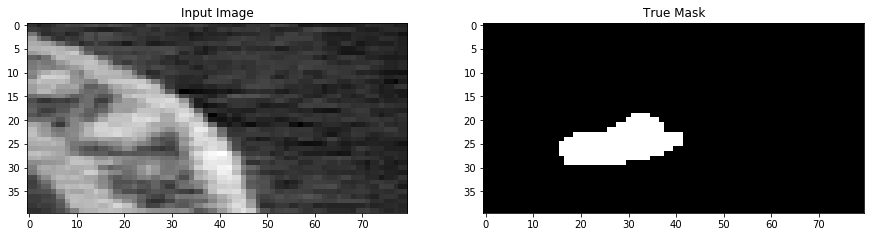

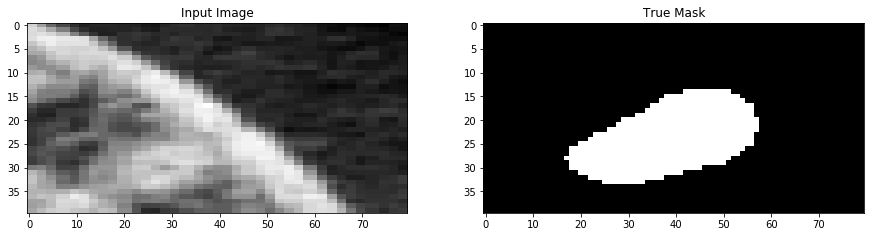

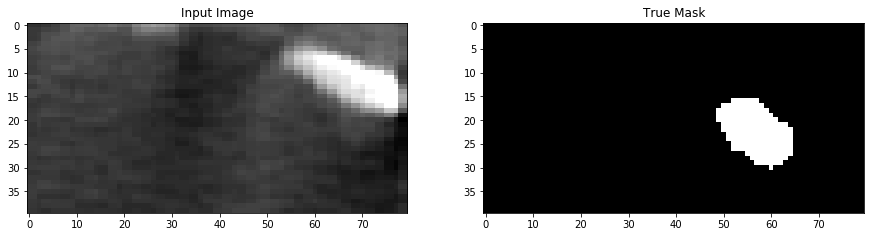

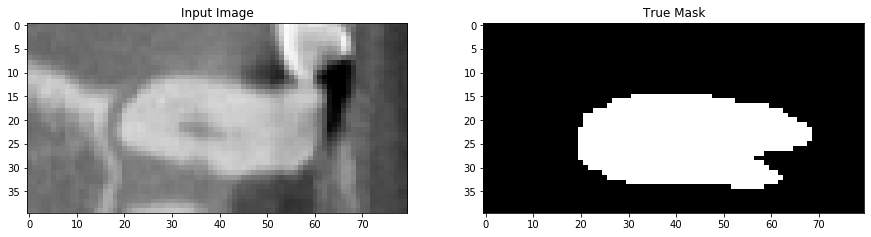

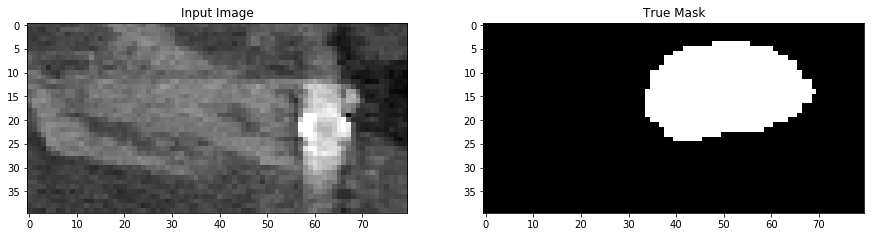

In [54]:
show_dataset(train_generator, 5)

In [55]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
    #    x = keras.layers.BatchNormalization()(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
 #       x = keras.layers.BatchNormalization()(x)
    x =  keras.layers.Dropout(0.8)(x)         
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [56]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = unet(4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 40, 80, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 40, 80, 32)   9248        conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 20, 40, 32)   0           conv2d_61[0][0]                  
________________________________________________________________________________________

In [58]:
begin = datetime.now()
current_time = begin.strftime("%H:%M:%S")
print("Current Time =", current_time)
    
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS,callbacks=[tensorboard_callback])

end = datetime.now()
current_time = end.strftime("%H:%M:%S")
print("Current Time =", current_time,"Difference",(end-begin))

Current Time = 22:00:10
Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/3 [===================>..........] - ETA: 0s - loss: 0.6833 - accuracy: 0.6376WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.246979). Check your callbacks.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

InvalidArgumentError:  Incompatible shapes: [7,1,40,80] vs. [28,1,40,80]
	 [[node binary_crossentropy/logistic_loss/mul (defined at <ipython-input-58-be74fee7bb6c>:10) ]] [Op:__inference_test_function_63027]

Function call stack:
test_function


In [12]:
model.save(f'model/UNET-2d{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [13]:
test_generator =  (pair for pair in create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1))

Found 2527 images belonging to 2 classes.
Found 2670 images belonging to 2 classes.


In [14]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


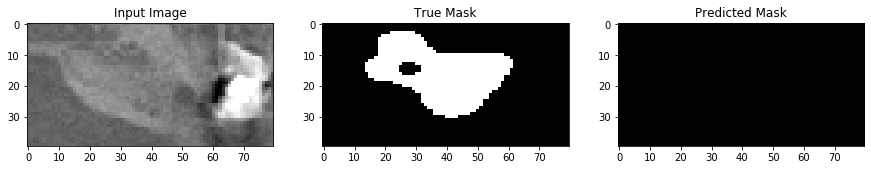

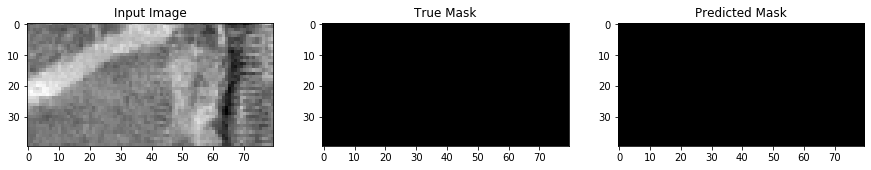

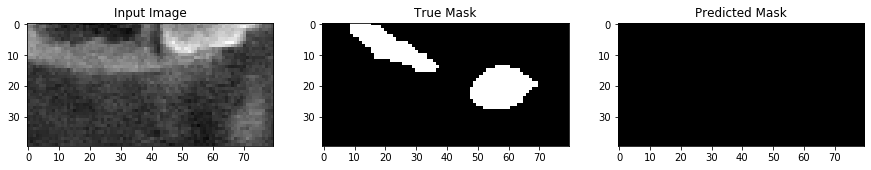

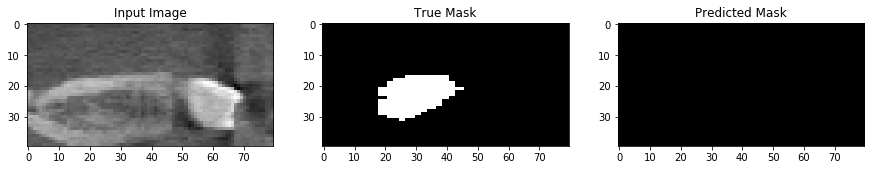

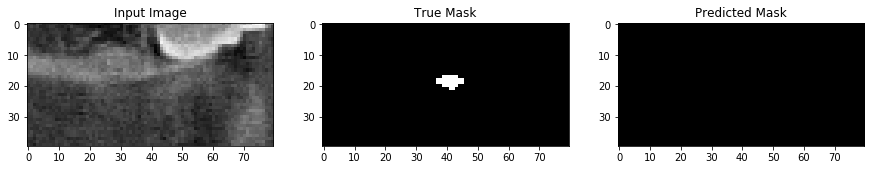

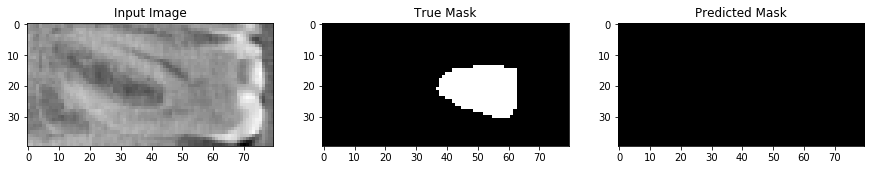

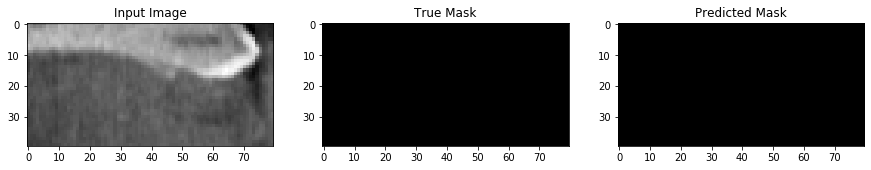

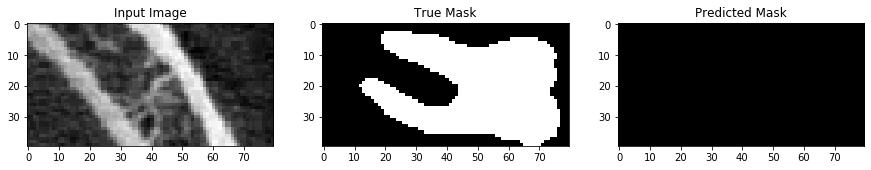

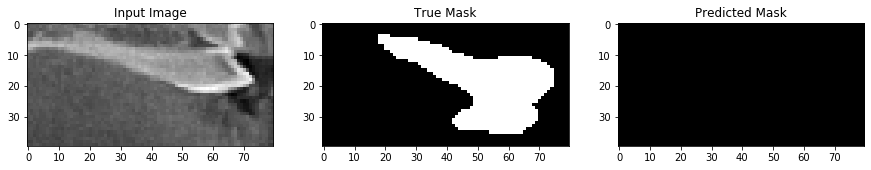

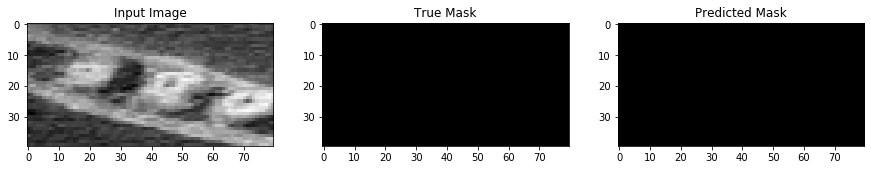

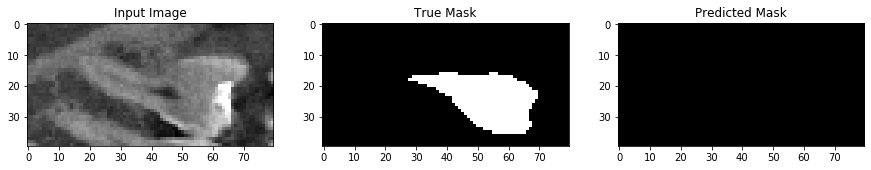

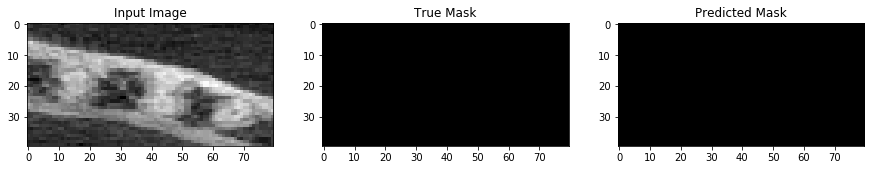

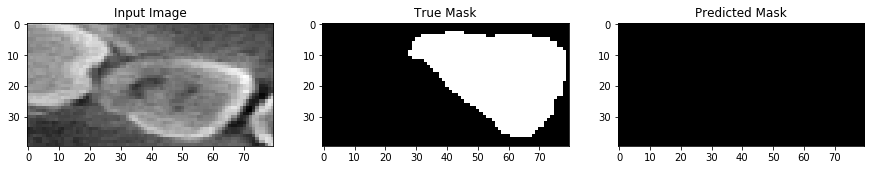

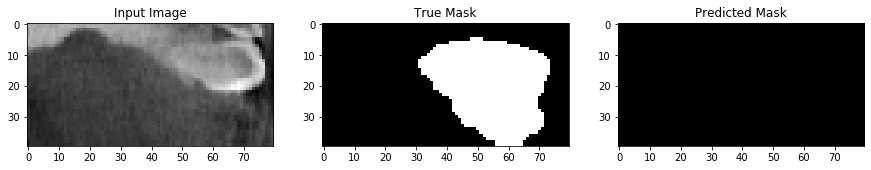

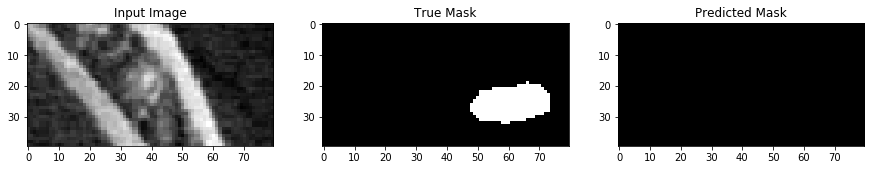

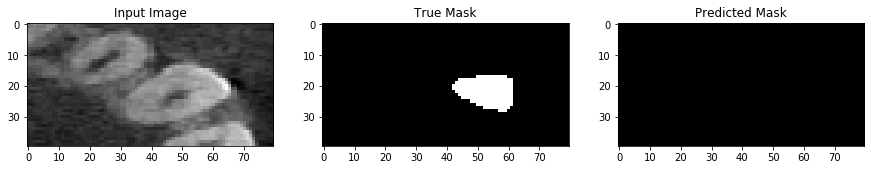

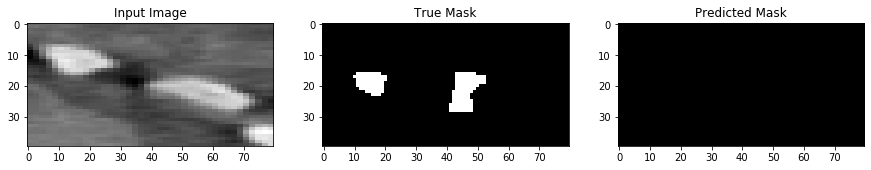

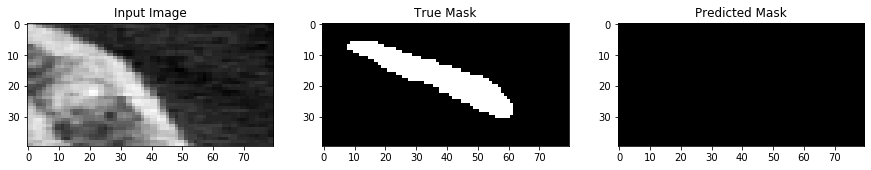

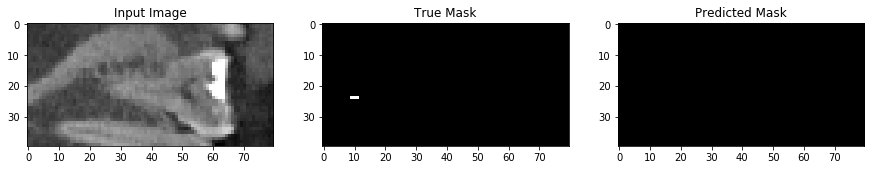

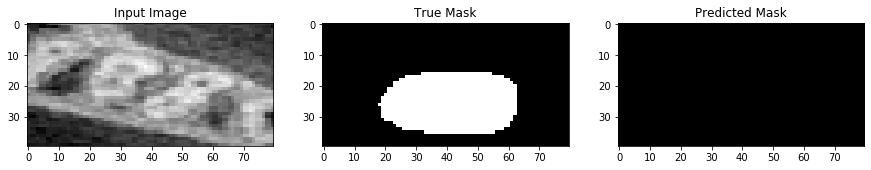

In [15]:
show_prediction(test_generator, 20)

In [286]:

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from niwidgets import NiftiWidget
import tensorflow as tf
from tensorflow.keras.preprocessing.image import * 
from tensorflow import keras
from config import *
from model import *
import math
import random
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops
from skimage.measure import label
import numpy as np
from skimage.util import montage, crop
from tensorflow.python.client import device_lib
from tensorflow.keras.metrics import MeanIoU,BinaryCrossentropy,Accuracy,Precision,Recall
from skimage.transform import rescale, resize, downscale_local_mean,rotate
from skimage import data, color
from scipy import ndimage
from scipy import misc
from numpy import fliplr
from datetime import *
from sklearn.model_selection import KFold
from dataAugmentation import *
import cv2
from tensorflow.keras.models import load_model
from skimage.util import random_noise
from skimage import exposure
from tensorflow.keras.losses import Reduction
from tensorflow.keras.losses import Loss

In [95]:
def load(task):
    model= None
    for m in os.listdir(os.path.join('model/UNET3D/',task)):
        return load_model(os.path.join('model/UNET3D/',task,m))
    return model
num=30
def show_dataset(data, num):    
    plt.figure(figsize=(15,15))
 #   file_writer = tf.summary.create_file_writer(logdir)
    for i in range(0,num):  
        i,l,pred = list(data)[i]
      #  print(labels.shape)
     #   print(l.shape)
        i=i[0]
        l=l[0]
        p = pred[0]
        fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,15))
        ax1.imshow(np.squeeze(i[num]), cmap="gray")
        ax2.imshow(np.squeeze(l[num]), cmap="gray")
        ax3.imshow(np.squeeze(p[num]), cmap="gray")
        
        
       
      
    plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


IndexError: list index out of range

<Figure size 1080x1080 with 0 Axes>

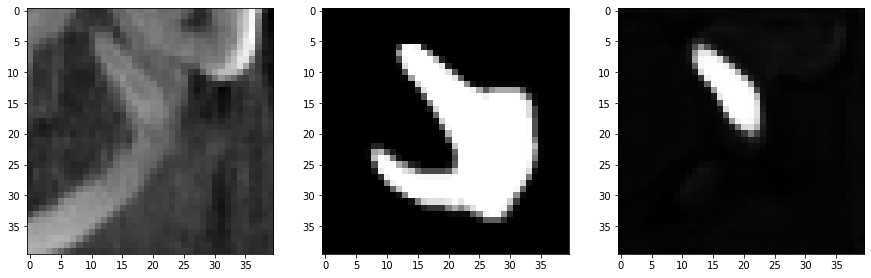

In [96]:
model = load('segmentation')
data=[]
shape = (40, 40,40)
for d in ['mandible-Right-Molar']  :
    for niiImage in os.listdir(os.path.join(data_dir_test_image,d)):
        if niiImage=='9.10.90.nii':
            img = nib.load( os.path.join(data_dir_test_image,d, niiImage))
            inputs = normalizeImageIntensityRange(img.get_fdata() ) 
          #  inputs = exposure.equalize_hist(inputs)
            mask = np.round(nib.load( os.path.join(data_dir_test_mask,d, niiImage)).get_fdata()) 

            resize_image = resize(inputs, shape, anti_aliasing=True)
            resize_mask = resize(mask, shape, anti_aliasing=True)    
            img_np = np.rollaxis(np.array(np.array([np.array([np.array(resize_image)]) ])),0,5)
            img_mask = np.rollaxis(np.array(np.array([np.array([np.array(resize_mask)]) ])),0,5)

        # @tf.autograph.experimental.do_not_convert
            pred1 = (model.predict(img_np)).astype(float) 
            data.append([img_np,img_mask,pred1]) 
        
show_dataset(data, 11)